In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.patches import Rectangle, Ellipse
from IPython.display import HTML

In [13]:
# EPS = 1e-6

## 1. DEFINE THE SKIN MODEL AND OPTICAL PROPERTIES

In [14]:
# Skin layer definitions (name, thickness in um)
# Based on Meglinski & Matcher, 2002
layer_defs = [
    # ("Air", 500),
    ("Stratum Corneum", 20),
    ("Living Epidermis", 80),
    ("Papillary Dermis", 150),
    ("Upper Blood Net", 100),
    ("Reticular Dermis", 1500),
    ("Deep Blood Net", 100),
    ("Subcutaneous Fat", 2000) # Truncated for visualization
]

In [15]:
# Calculate layer boundaries (z-coordinates)
# We place the skin surface at z=0 and go downwards (negative z)
layer_thicknesses = [d[1] for d in layer_defs]
layer_boundaries = -np.cumsum([0] + layer_thicknesses)
total_depth = layer_boundaries[-1]
skin_width = 3000 # um

In [16]:
# Simplified optical properties for visualization
# We define a base mu_a and mu_s for each layer
# Hemoglobin absorption will be added on top of this
# Format: { 'mu_a': base_absorption, 'mu_s': scattering, 'g': anisotropy }
layer_optical_props = {
    # "Air": {'mu_a': 1e-10, 'mu_s': 1e-10, 'g': 1e-10},
    "Stratum Corneum":  {'mu_a': 0.05, 'mu_s': 40.0, 'g': 0.85},
    "Living Epidermis": {'mu_a': 0.1,  'mu_s': 30.0, 'g': 0.8},
    "Papillary Dermis": {'mu_a': 0.05, 'mu_s': 25.0, 'g': 0.9},
    "Upper Blood Net":  {'mu_a': 0.05, 'mu_s': 30.0, 'g': 0.95},
    "Reticular Dermis": {'mu_a': 0.02, 'mu_s': 20.0, 'g': 0.8},
    "Deep Blood Net":   {'mu_a': 0.02, 'mu_s': 25.0, 'g': 0.95},
    "Subcutaneous Fat": {'mu_a': 0.01, 'mu_s': 15.0, 'g': 0.75}
}

In [17]:
# Define Hemangioma region (an ellipse)
hemangioma_center = (skin_width / 2, layer_boundaries[3] - 50)
hemangioma_width = 800
hemangioma_height = 300
hemangioma_ellipse = Ellipse(hemangioma_center, hemangioma_width, hemangioma_height, angle=0)

In [18]:
# Wavelength-dependent properties (simplified for visualization)
# Relative absorption multiplier for hemoglobin at different wavelengths
wavelengths = {
    'Blue (470nm)':  {'color': '#0077FF', 'hb_abs': 15.0},
    'Green (520nm)': {'color': '#00FF77', 'hb_abs': 25.0},
    'Red (660nm)':   {'color': '#FF5555', 'hb_abs': 1.0},
    'NIR (850nm)':   {'color': '#DDA0DD', 'hb_abs': 0.5}
}

## 2. PHOTON MONTE CARLO ENGINE (SIMPLIFIED)

In [19]:
class Photon:
    def __init__(self, x, z, wavelength_name):
        self.wavelength_name = wavelength_name
        self.color = wavelengths[wavelength_name]['color']
        self.hb_absorption_multiplier = wavelengths[wavelength_name]['hb_abs']
        
        self.x_path = [x]
        self.z_path = [z]
        self.x = x
        self.z = z
        self.ux = 0.0  # direction vector x
        self.uz = -1.0 # direction vector z (initially straight down)
        self.weight = 1.0
        self.is_alive = True

    def get_current_layer(self):
        # Find which layer the photon is currently in based on its z-depth
        for i, boundary in enumerate(layer_boundaries[1:]):
            if self.z > boundary:
                return layer_defs[i][0]
        return layer_defs[-1][0] # If deeper than all boundaries, it's in the last layer

    def move(self):
        if not self.is_alive:
            return
            
        layer_name = self.get_current_layer()
        props = layer_optical_props[layer_name]
        mu_s = props['mu_s'] / 1000.0 # convert from mm^-1 to um^-1
        mu_a_base = props['mu_a'] / 1000.0
        g = props['g']

        # Add extra absorption if the photon is inside the hemangioma
        mu_a = mu_a_base
        if hemangioma_ellipse.contains_point((self.x, self.z)):
            # Drastically increase absorption in hemangioma based on wavelength
            mu_a += (self.hb_absorption_multiplier * 0.1) / 1000.0

        mu_t = mu_a + mu_s
        if mu_t <= 0: # Avoid division by zero
            self.is_alive = False
            return
        
        # 1. Move photon by a random step length based on total interaction coefficient
        step = -np.log(np.random.rand()) / mu_t
        self.x += self.ux * step
        self.z += self.uz * step
        
        self.x_path.append(self.x)
        self.z_path.append(self.z)

        # 2. Absorb energy (reduce photon weight)
        delta_weight = self.weight * (mu_a / mu_t)
        self.weight -= delta_weight

        # 3. Scatter (change direction) using Henyey-Greenstein
        if g == 0: # Isotropic scattering
            cos_theta = 2 * np.random.rand() - 1
        else: # Anisotropic scattering
            # This formula calculates the cosine of the scattering angle
            temp = (1 - g**2) / (1 - g + 2 * g * np.random.rand())
            cos_theta = (1 + g**2 - temp**2) / (2 * g)
        
        # --- DEBUGGED SCATTERING LOGIC ---
        # We use a simpler, more stable 2D rotation
        rot_angle = np.random.choice([-1, 1]) * np.arccos(cos_theta)
        c, s = np.cos(rot_angle), np.sin(rot_angle)
        
        # Apply 2D rotation matrix to the direction vector (ux, uz)
        new_ux = self.ux * c - self.uz * s
        new_uz = self.ux * s + self.uz * c
        self.ux, self.uz = new_ux, new_uz
        # --- END OF DEBUGGED SECTION ---

        # 4. Check for termination conditions
        # Use Russian Roulette for termination to be more physically accurate,
        # but a simple weight threshold is fine for visualization.
        if self.weight < 0.001:
            self.is_alive = False
        
        # Terminate if photon leaves the simulation area
        if self.z < total_depth or self.x < 0 or self.x > skin_width:
            self.is_alive = False
        
        # Terminate if photon exits back through the skin surface
        if self.z > 0:
            self.is_alive = False

## 3. SETUP THE ANIMATION

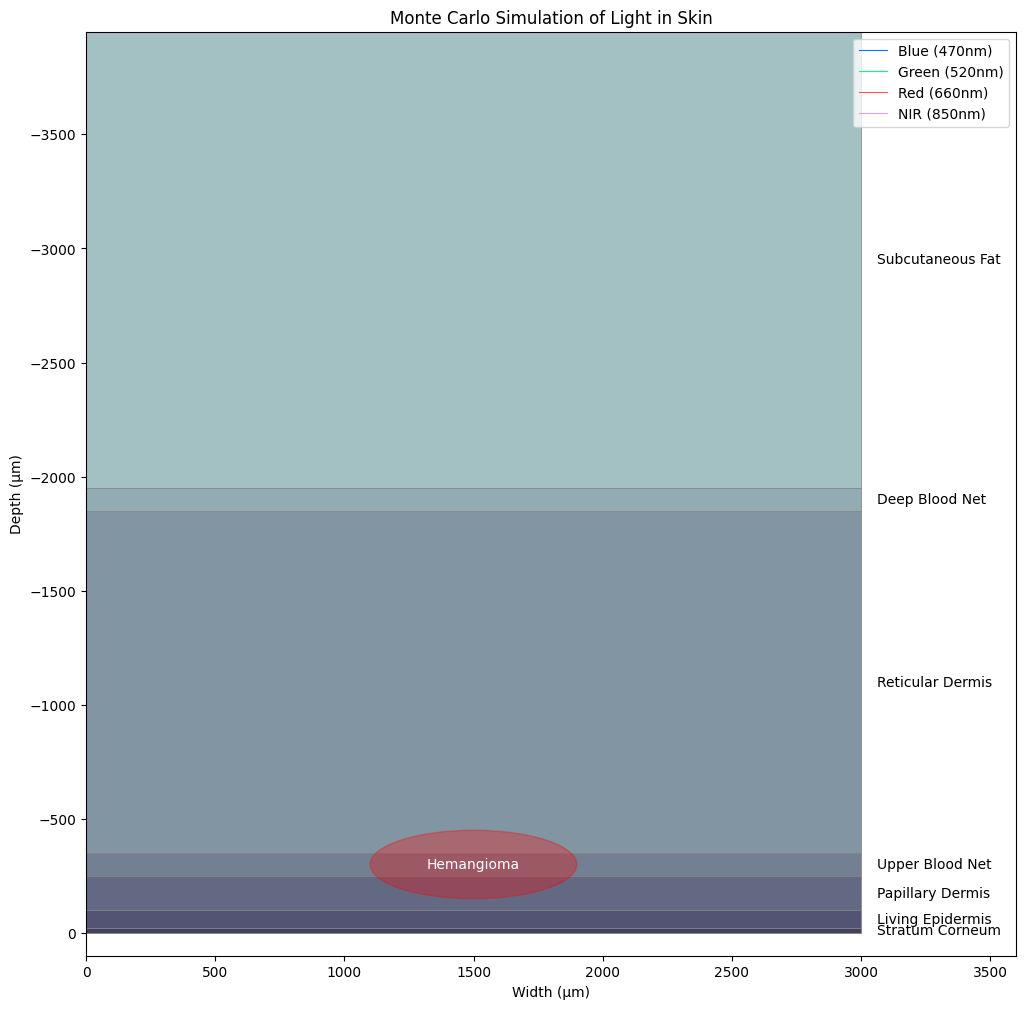

In [20]:
# Create photons for each wavelength
photons = []
num_photons_per_wl = 25
for wl_name in wavelengths:
    for i in range(num_photons_per_wl):
        # Start photons from a small area on the surface
        start_x = skin_width / 2 + (np.random.rand() - 0.5) * 50
        photons.append(Photon(start_x, 0, wl_name))

fig, ax = plt.subplots(figsize=(12, 12))

# Plot the skin layers
for i, layer in enumerate(layer_defs):
    name, thickness = layer
    ax.add_patch(Rectangle((0, layer_boundaries[i+1]), skin_width, thickness, 
                           facecolor=plt.cm.bone(i / len(layer_defs) * 0.5 + 0.3), 
                           edgecolor='gray', lw=0.5))
    ax.text(skin_width * 1.02, layer_boundaries[i+1] + thickness/2, f"{name}", va='center')

# Plot the hemangioma
hemangioma_patch = Ellipse(hemangioma_center, hemangioma_width, hemangioma_height, 
                           facecolor='red', alpha=0.3, edgecolor='red', lw=1)
ax.add_patch(hemangioma_patch)
ax.text(hemangioma_center[0], hemangioma_center[1], "Hemangioma", color='white', ha='center', va='center')

# Prepare lines for photon paths
# lines = [ax.plot([], [], lw=0.8, color=p.color, label=p.wavelength_name if i < num_photons_per_wl else "")[0] for i, p in enumerate(photons)]
# Prepare lines for photon paths
lines = []
for wl_idx, wl_name in enumerate(wavelengths):
    for i in range(num_photons_per_wl):
        photon_idx = wl_idx * num_photons_per_wl + i
        p = photons[photon_idx]
        label = wl_name if i == 0 else ""
        lines.append(ax.plot([], [], lw=0.8, color=p.color, label=label)[0])

def init():
    ax.set_xlim(0, skin_width * 1.2)
    ax.set_ylim(total_depth, 100)
    ax.set_xlabel("Width (μm)")
    ax.set_ylabel("Depth (μm)")
    ax.set_title("Monte Carlo Simulation of Light in Skin")
    ax.invert_yaxis()
    
    # Create a unique legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper right')
    
    for line in lines:
        line.set_data([], [])
    return lines

def animate(frame):
    for i, p in enumerate(photons):
        # Move each photon for a few steps per frame to speed up animation
        for _ in range(5): 
            p.move()
        lines[i].set_data(p.x_path, p.z_path)
    return lines

# Create the animation object
# Note: This can be computationally intensive. `frames` controls the length.
ani = FuncAnimation(fig, animate, init_func=init, frames=300, interval=20, blit=True)

## RENDER THE ANIMATION AS HTML5 VIDEO

In [21]:
plt.close(fig) # Prevent a static plot from showing up
HTML(ani.to_html5_video())